### Assignment Overview
<p>We will predict the class of breast cancer (malignant or ‘bad’ versus benign or ‘good’) from the features of images taken from breast samples. Breast cancer is a type of cancer that forms in the cells of the breasts.
After skin cancer, it is the most common cancer diagnosed in women. Although it can occur in both men and women, it is far more common in women.

Support for breast cancer awareness and research has helped create advances in the diagnosis and treatment of breast cancer. Breast cancer survival rates have increased & the number of deaths associated with this disease is steadily declining, largely due to factors such as earlier detection, a new personalized approach to treatment and a better understanding of the disease.</p>

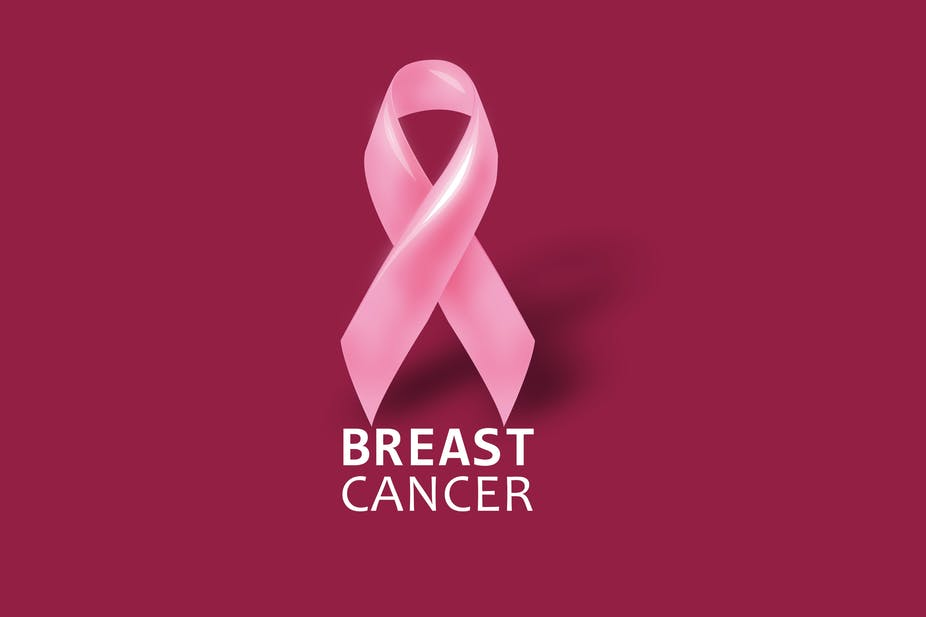

#### Required Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
help(pd.read_csv)

In [2]:
cols = "ID_number Clump_Thickness Cell_Size_Uniformity Cell_Shape_Uniformity Marginal_Adhesion Single_Epithelial_Cell_Size Bare_Nuclei Bland_Chromatin Normal_Nucleoli Mitoses Class"
print(cols.split())

['ID_number', 'Clump_Thickness', 'Cell_Size_Uniformity', 'Cell_Shape_Uniformity', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class']


In [6]:
bc = pd.read_csv("data/cancer.data", header=None, index_col=None, names=cols)
bc.head(3)

ValueError: Duplicate names are not allowed.

#### Renaming Columns

In [ ]:
bc.rename(columns = 
          {0:'ID number',
           1:'Clump Thickness', 
           2:'Cell Size Uniformity',
           3:'Cell Shape Uniformity', 
           4:'Marginal Adhesion',
           5:'Single Epithelial Cell Size',
           6:'Bare Nuclei',
           7:'Bland Chromatin',
           8:'Normal Nucleoli',
           9:'Mitoses', 
           10:'Class'
}, inplace=True)

In [ ]:
# bc.head(3)

#### Inspecting Data

In [ ]:
bc.info()

Bare Nuclei is an object type indicating that it doesn't have only numeric values. This must be investigated.

In [ ]:
bc['Bare Nuclei'].value_counts()

In [ ]:
bc = bc.replace('?', np.nan)

In [ ]:
# Iterate over each column of bc
for col in bc:
    # Check if the column is of object type
    if bc[col].dtypes == 'object':
        # Impute with the most frequent value
        bc = bc.fillna(bc[col].value_counts().index[0])

bc.isnull().sum()

In [ ]:
bc.describe()

In [ ]:
# bc.info()

In [ ]:
from sklearn.preprocessing import LabelEncoder 

le =  LabelEncoder()

# Iterate over all the values of each column and extract their dtypes
for col in bc:
    if bc[col].dtype=='object':
    # Use LabelEncoder to do the numeric transformation
        bc[col]=le.fit_transform(bc[col])

In [ ]:
bc.dtypes

Objects have successfully been changed to integers

In [ ]:
bc = bc.values

In [ ]:
# Segregate features and labels into separate variables
X,y = bc[:,0:10] , bc[:,10]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler and rescale X
mmscaler = MinMaxScaler(feature_range=(0, 1))
X_transformed = mmscaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)

#### Creating Logistic Regesssion Model

In [ ]:
logreg = LogisticRegression()
#Fit model to data
logreg.fit(X_train,y_train)

__The logreg now holds a logistic regression model that is fit to the data.__

# Examining Coeficients & Intercepts

In [ ]:
coef = logreg.coef_
print(coef)

intercept = logreg.intercept_
print(intercept)

It is interesting to have a look at the coefficients to check whether the model makes sense.

Given our fitted logistic regression model logreg, you can retrieve the coefficients using the attribute __coef_.__ The order in which the coefficients appear is the same as the order in which the variables were fed to the model. The intercept can be retrieved using the attribute __intercept_.__

For example, the coefficient associated with Clump Thickness is positive. This means it is positively correlated with the target.

In [ ]:
y_pred = logreg.predict(X_test)

# Get accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", logreg.score(X_test, y_test))

In [ ]:
from sklearn.metrics import confusion_matrix
# confusion matrix of the logreg model
confusion_matrix(y_pred, y_test)

In [ ]:
from sklearn.metrics import classification_report
label= ['Benign', 'Malignant']
print(classification_report(y_test, y_pred, target_names= label))

### ROC Curve

A Receiver Operator Characteristic (ROC) curve is a graphical plot used to show the diagnostic ability of binary classifiers.
"It is nothing but a graph displaying the performance of a classification model. It is a very popular method to measure the accuracy of a classification model"

reference: https://towardsdatascience.com/roc-curve-in-machine-learning-fea29b14d133

In [ ]:
# from sklearn.metrics import roc_curve

# fpr, tpr, threshold = roc_curve(y_test, logreg.predict_proba(X_test))
# # roc_auc = metrics.auc(fpr, tpr)

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
# !pip install scikitplot

In [ ]:
# import scikitplot as skplt
# import matplotlib.pyplot as plt

# y_true = probs[:,1]
# # ground truth labels
# y_probas = logreg.predict_proba(X_test)
# # predicted probabilities generated by sklearn classifier

# skplt.metrics.plot_roc_curve(y_true, y_probas)
# plt.show()

#### Overdispersion

Overdispersion is the presence of greater variability (statistical dispersion) in a data set than would be expected based on a given model.